# Imports

In [1]:
import os
from typing import Tuple, Callable

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Functions

In [2]:
def plot_column_distribution(col: pd.Series, title: str, figsize: Tuple[int, int]=(15, 5)) -> None:
    plt.figure(figsize=figsize)
    sns.countplot(x=col)
    plt.title(title)
    plt.show()

# Dataset

In [3]:
DATA_FOLDER = 'data'
PARTS = 'sent'
NUM_PARTS = 1

def get_dataset(idx: int) -> pd.DataFrame:
    return pd.read_orc(os.path.join(DATA_FOLDER, f'{PARTS}_{idx}.orc'))


In [4]:
df = get_dataset(1)
df

,init_words,mod_words,pos_tags
0,"[უკვე, შვიდი, თვეა, ,, ერთმანეთს, ვიცნობთ, .]","[უკვე, შვიდი, თვეა, ,, ერთმანეთს, ვიცნობთ, .]","[Adv, Num, N, Punct, Pron, V, Punct]"
1,"[და, არაფერი, მიამბე, !]","[და, არაფერი, მიამბე, !]","[Cj, Pron, V, Punct]"
2,"[მერედა, რა, გამოვიდა, იქედან, ,, რომ, გიამბობ...","[მერედა, რა, გამოვიდა, იქედან, ,, რომ, გიამბობ...","[Adv, Pron, V, Adv, Punct, Cj, V, Punct, Punct]"
3,"[უკვე, დარბაზიც, შევუკვეთეთ, …, რას, იტყვი, ?]","[უკვე, დარბაზიც, შევუკვეთეთ, …, რას, იტყვი, ?]","[Adv, N, V, Punct, Pron, V, Punct]"
4,"[ისიც, ჩემს, წინ, დადგა, .]","[ისიც, ჩემს, წინ, დადგა, .]","[Pron, Pron, Pp, V, Punct]"
...,...,...,...
999994,"[ამგვარი, შეზღუდვის, დაწესებას, ,, სხვა, სიახლ...","[ამგვარი, შეზღუდვის, დაწესებას, ,, სხვა, სიახლ...","[A, N, N, Punct, A, N, Pp, Punct, V, N, A, N, ..."
999995,"[მისი, ერთ-ერთი, ავტორის, ,, საპროცედურო, საკი...","[მისი, ერთ-ერთი, ავტორის, ,, საპროცედურო, საკი...","[Pron, A, N, Punct, A, N, Cj, N, N, A, N, N, N..."
999996,"[მისი, თქმით, ,, ყველა, დარბაზში, სხვადასხვა, ...","[მისი, თქმით, ,, ყველა, დარბაზში, სხვადასხვა, ...","[Pron, N, Punct, A, N, A, N, A, V, Num, N, Pun..."
999997,"[სავარაუდოდ, ,, ხელმისაწვდომი, აღარ, იქნება, პ...","[სავარაუდოდ, ,, ხელმისაწვდომი, აღარ, იქნება, პ...","[A, Punct, A, Adv, V, N, N, N, A, N, Cj, A, Pp..."


In [4]:
def get_total_statistics(modification: Callable[[pd.DataFrame], pd.Series]) -> pd.Series:
    col = pd.Series()
    for idx in range(1, NUM_PARTS + 1):
        df = get_dataset(idx)
        df = df[df.pos_tags.apply(lambda l: len(l)) > 0]
        col = pd.concat([col, modification(df)])
    return col

## Sentence lengths

In [6]:
length_statistics = get_total_statistics(lambda df: df.pos_tags.apply(lambda l: len(l)))

In [7]:
length_statistics.describe()

count   8493276.000
mean         15.966
std          10.271
min           2.000
25%           9.000
50%          14.000
75%          21.000
max        1014.000
dtype: float64

In [8]:
MAX_LENGTH = length_statistics.quantile(0.95)
length_statistics =  length_statistics[(length_statistics < MAX_LENGTH) & (length_statistics != 0)]
MAX_LENGTH

35.0

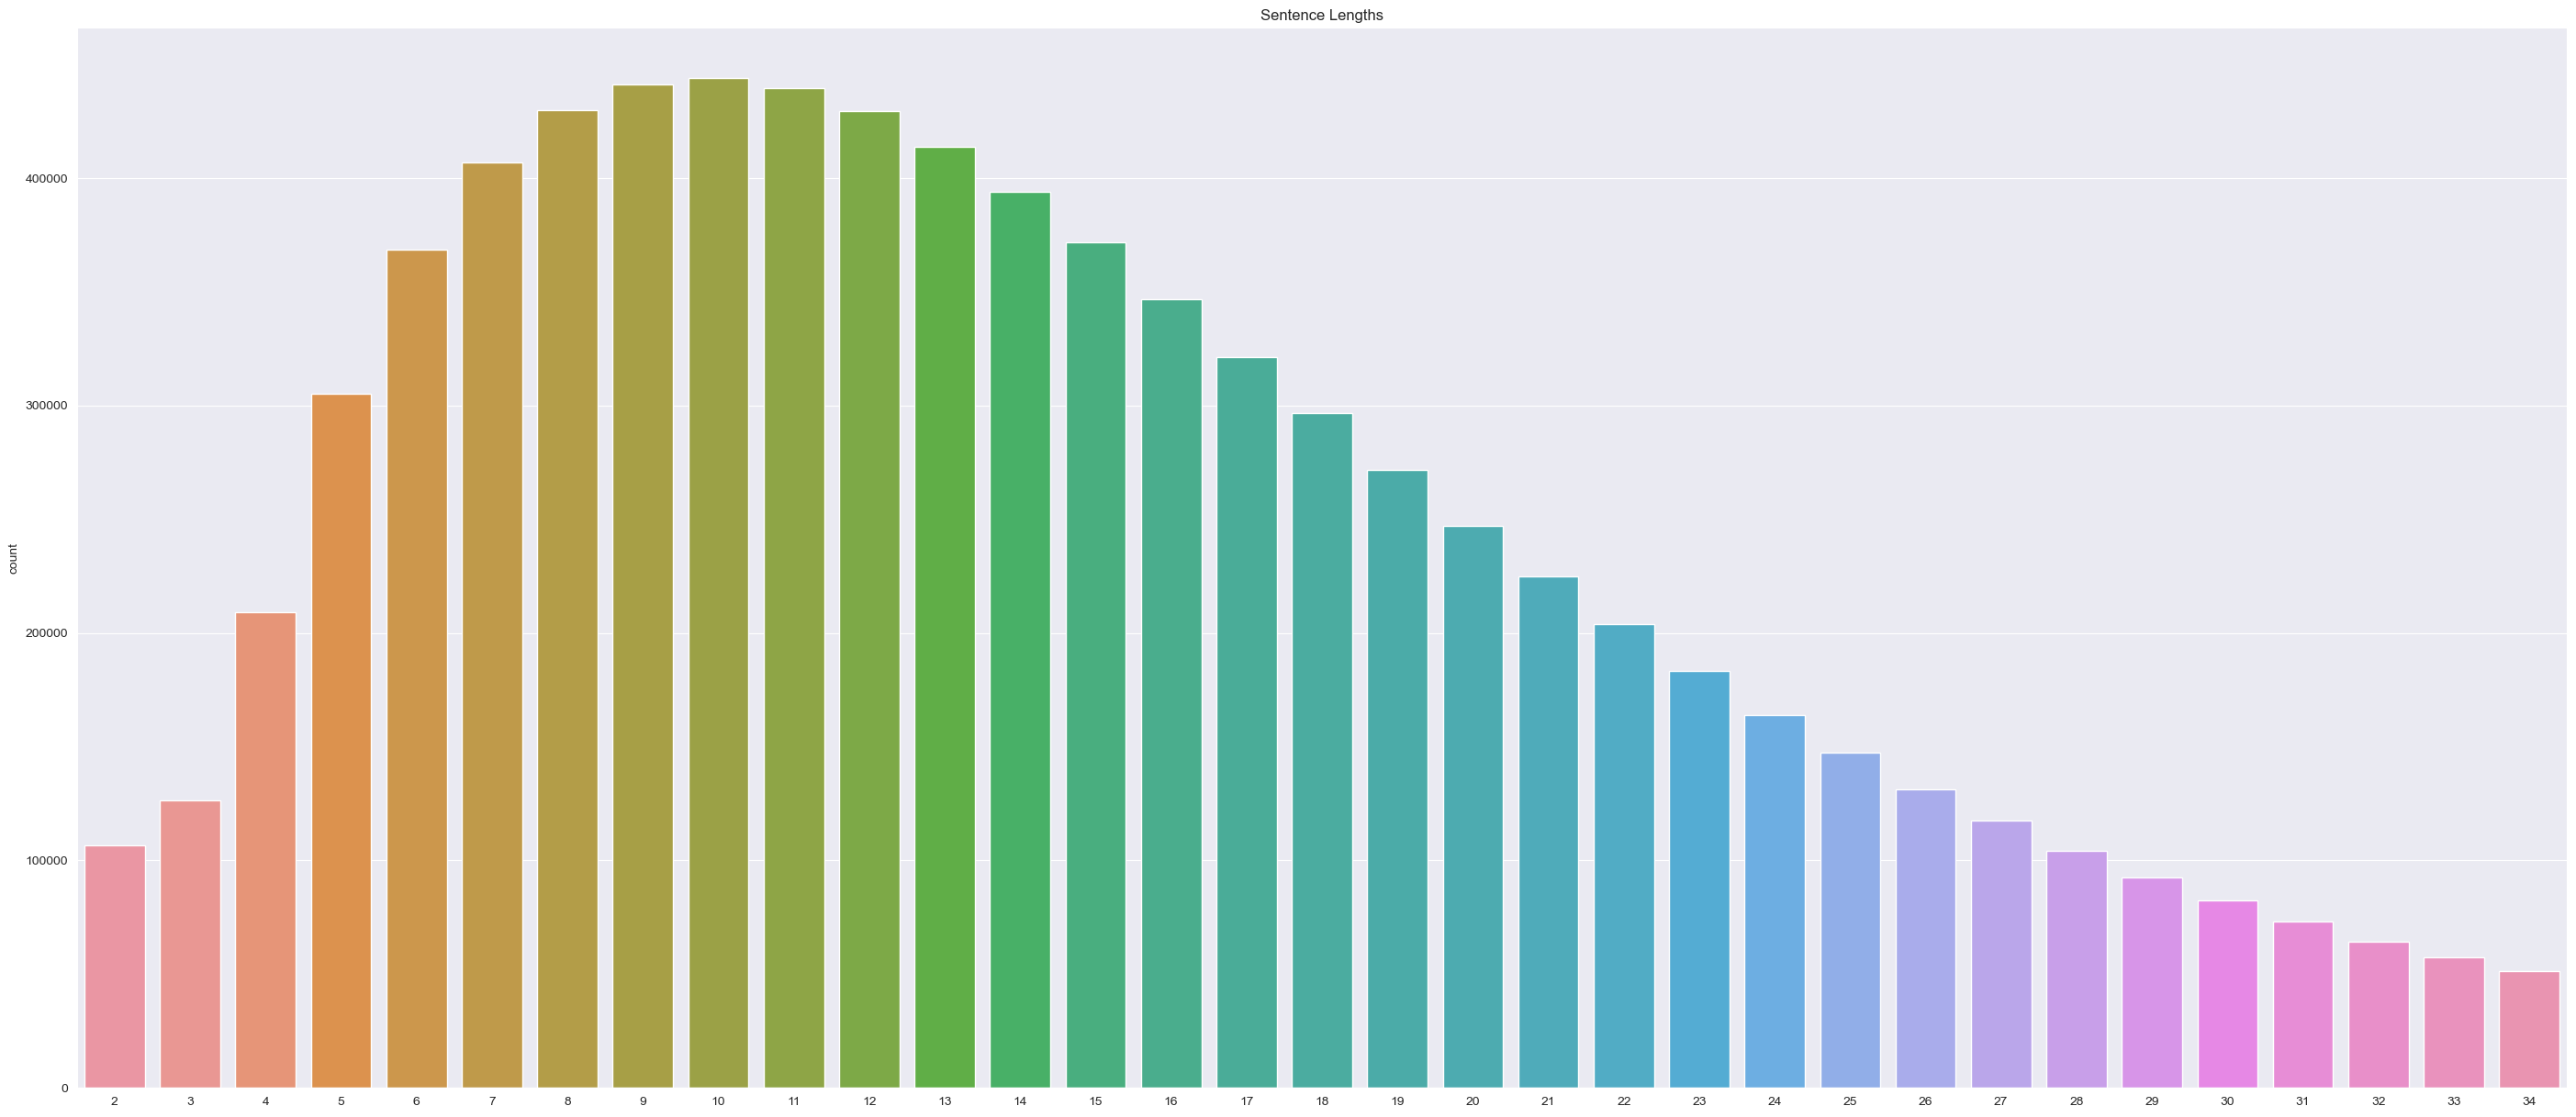

In [9]:
plot_column_distribution(length_statistics, 'Sentence Lengths', figsize=(35, 15))

In [150]:
length_df = pd.concat([length_statistics, pd.qcut(length_statistics, 3, labels=['low', 'medium', 'high'])], axis=1)
length_df

,0,1
0,7,low
1,4,low
2,9,low
3,7,low
4,5,low
...,...,...
493272,11,medium
493273,24,high
493274,16,medium
493275,8,low


In [152]:
length_df[1] == 'low'

0          True
1          True
2          True
3          True
4          True
          ...  
493272    False
493273    False
493274    False
493275     True
493276    False
Name: 1, Length: 7541007, dtype: bool

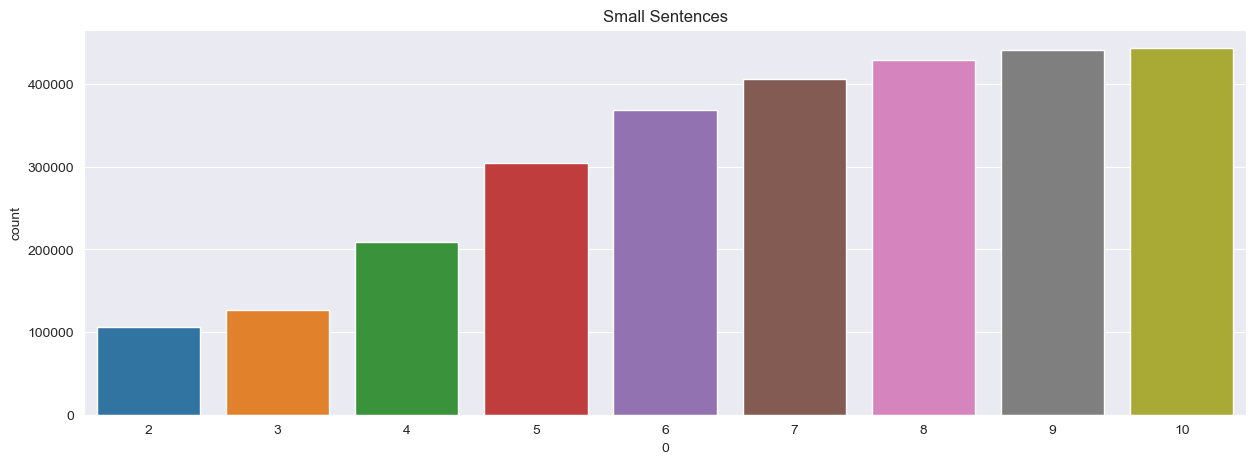

In [154]:
plot_column_distribution(length_df[length_df[1] == 'low'][0], 'Small Sentences')

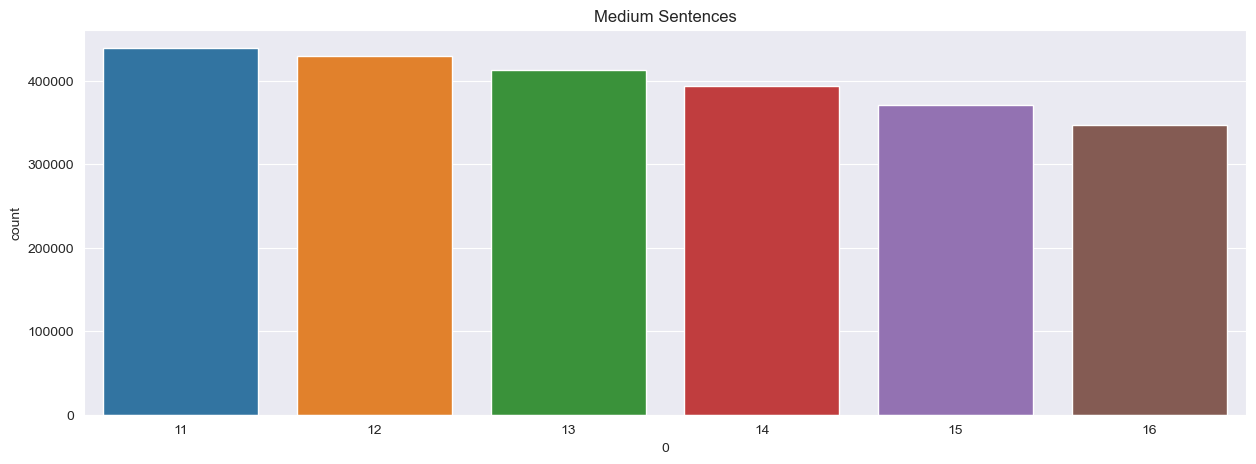

In [155]:
plot_column_distribution(length_df[length_df[1] == 'medium'][0], 'Medium Sentences')

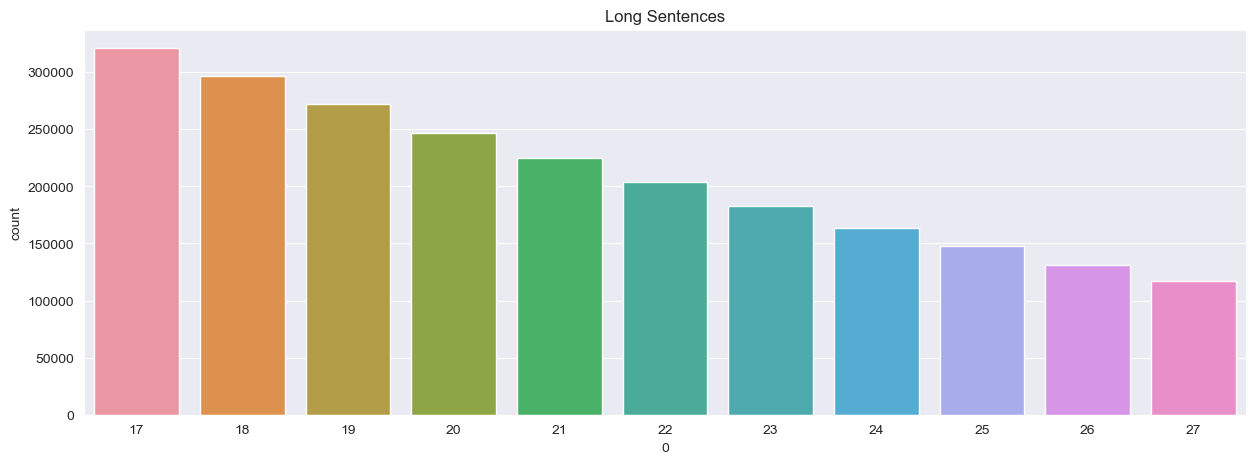

In [156]:
plot_column_distribution(length_df[length_df[1] == 'high'][0], 'Long Sentences')

In [10]:
def normalize_length(data: pd.DataFrame, max_len: int = MAX_LENGTH, min_len: int = 1) -> pd.DataFrame:
    return data[(data.pos_tags.apply(lambda l: len(l)) >= min_len) & (data.pos_tags.apply(lambda l: len(l)) <= max_len) ]

In [112]:
pos_tags_statistics =  get_total_statistics(lambda df: df.pos_tags.apply(lambda l: pd.Series(l).value_counts()).fillna(0) ) # counts of pos tags per sentence

In [127]:
pos_tags_statistics = pos_tags_statistics.drop(0,axis=1)
pos_tags_statistics = pos_tags_statistics[(pos_tags_statistics.sum(axis=1) > 0) & (pos_tags_statistics.sum(axis=1) < MAX_LENGTH)]
pos_tags_statistics

,Punct,Adv,Num,N,Pron,V,Cj,Pp,A,Other,Interj
0,2.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000
1,1.000,0.000,0.000,0.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000
2,3.000,2.000,0.000,0.000,1.000,2.000,1.000,0.000,0.000,0.000,0.000
3,2.000,1.000,0.000,1.000,1.000,2.000,0.000,0.000,0.000,0.000,0.000
4,1.000,0.000,0.000,0.000,2.000,1.000,0.000,1.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...
493272,1.000,1.000,0.000,7.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000
493273,3.000,0.000,0.000,8.000,0.000,4.000,4.000,0.000,5.000,0.000,0.000
493274,3.000,2.000,0.000,8.000,0.000,2.000,1.000,0.000,0.000,0.000,0.000
493275,3.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,2.000,0.000,0.000


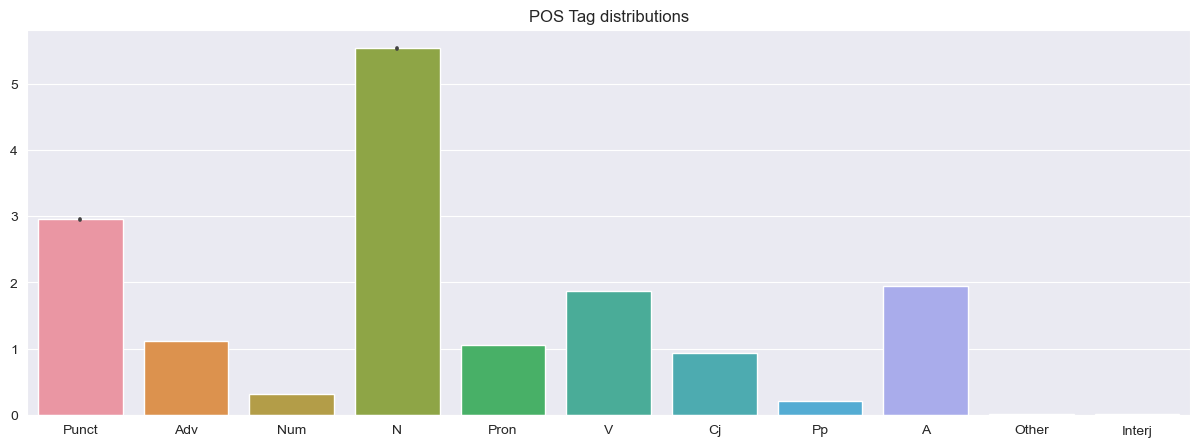

In [125]:
plt.figure(figsize=(15, 5))
sns.barplot(pos_tags_statistics)
plt.title('POS Tag distributions')
plt.show()

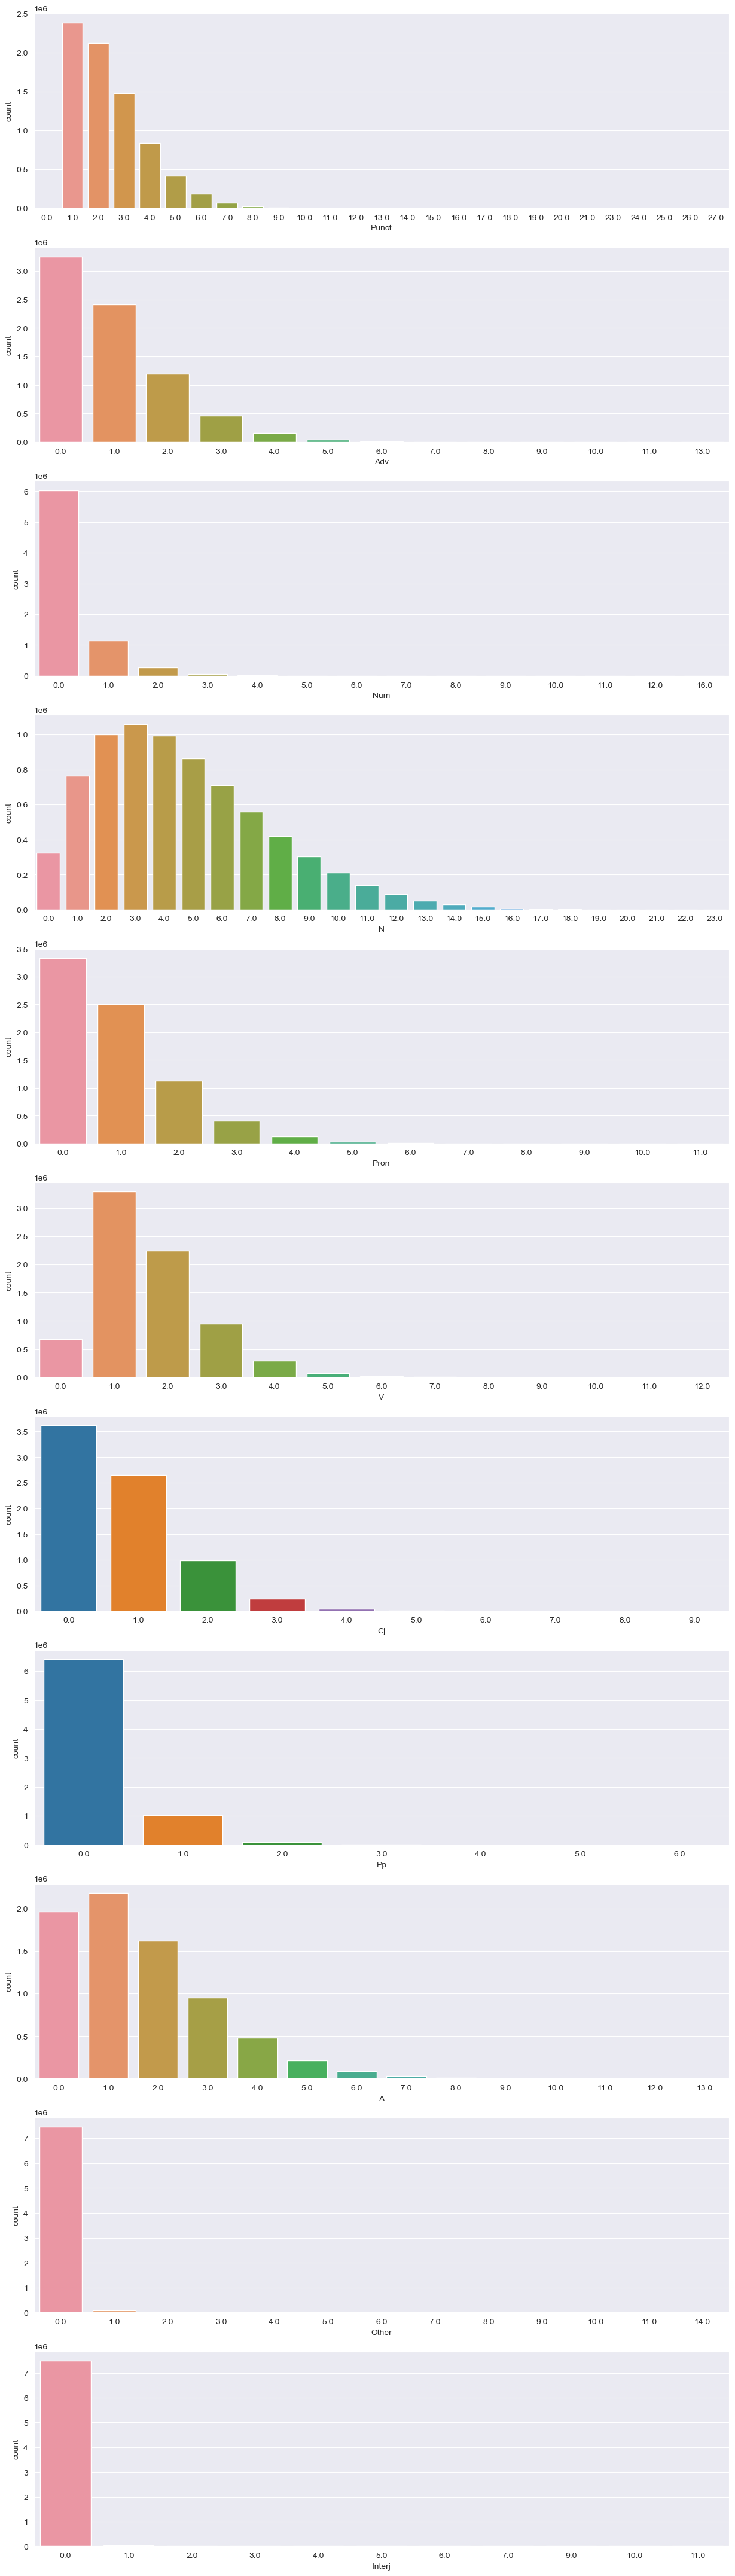

In [128]:
pos_tags = pos_tags_statistics.columns
fig, axs = plt.subplots(nrows=len(pos_tags), figsize=(15, 5 * len(pos_tags)))
for idx, pos_tag in enumerate(pos_tags):
    sns.countplot(pos_tags_statistics, x=pos_tag, ax=axs[idx])

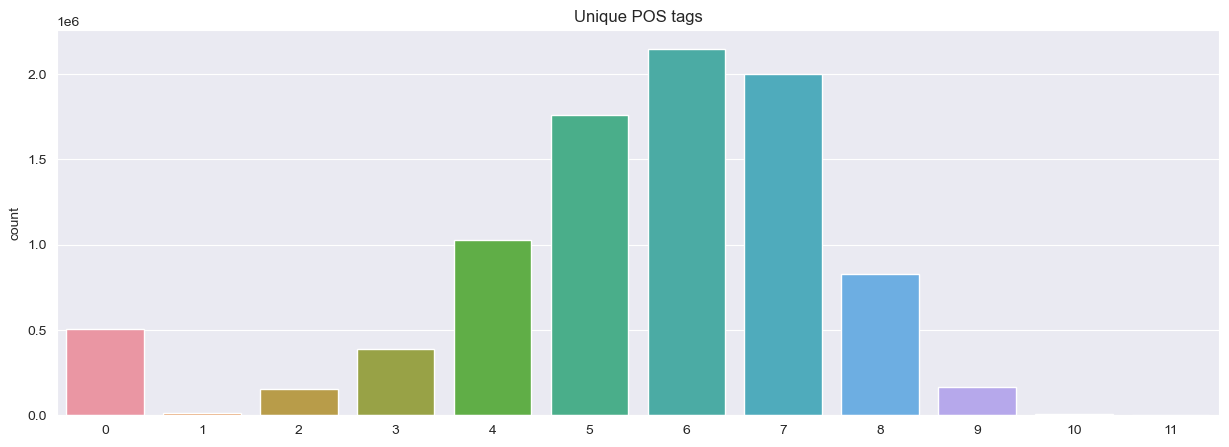

In [111]:
unique_pos_tags = get_total_statistics(lambda df: df.pos_tags.apply(lambda l: len(set(l))))
unique_pos_tags = unique_pos_tags[unique_pos_tags > 0]
plot_column_distribution(unique_pos_tags, 'Unique POS tags')

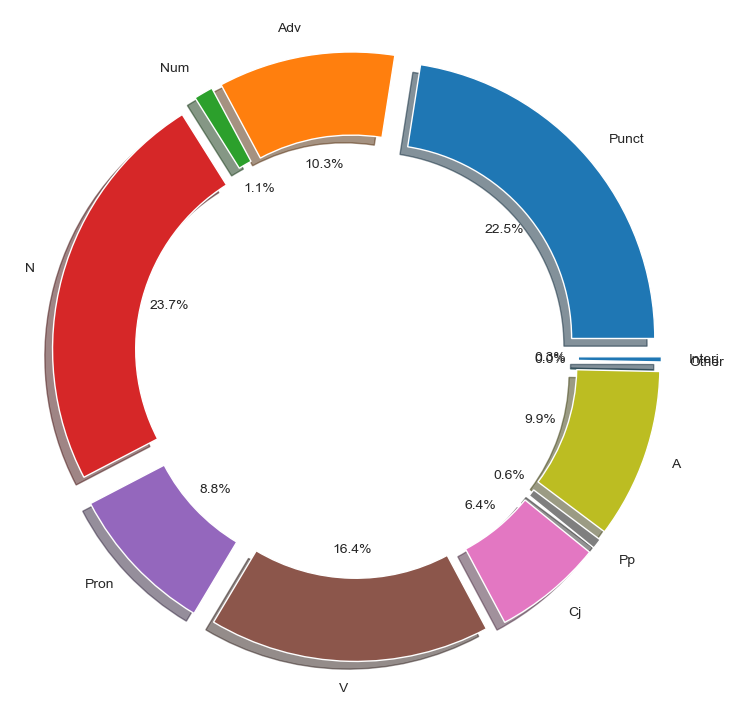

In [70]:
plt.figure(figsize=(9, 9))
dist = pos_tags_statistics.sum(axis=0)/ pos_tags_statistics.sum(axis=0).sum()
explode = ([0.1] * len(dist))
plt.pie(list(dist), labels=dist.index, explode=explode, shadow=True, autopct='%1.1f%%', wedgeprops=dict(width=0.3))
plt.show()

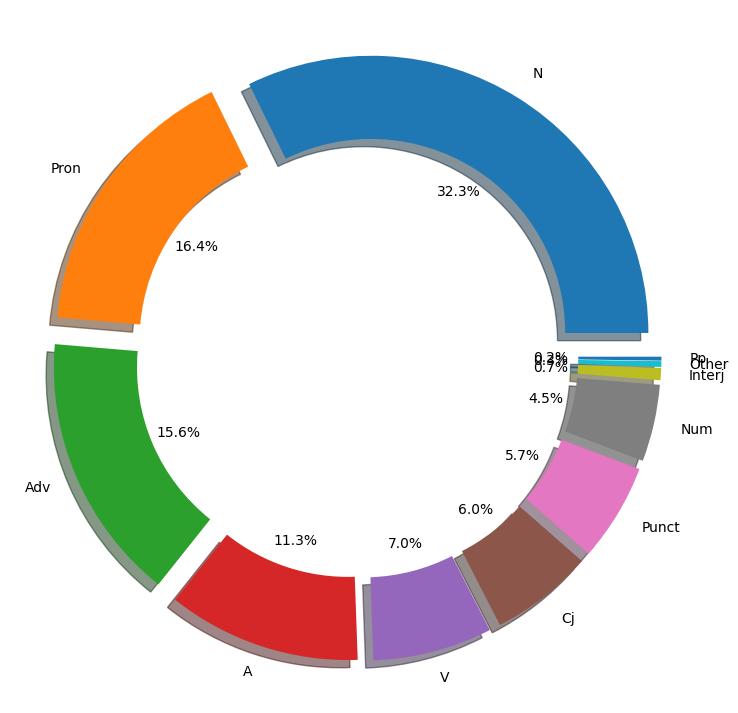

In [15]:
plt.figure(figsize=(9, 9))
first_pos_dist = get_total_statistics(lambda df: df.pos_tags.apply(lambda l: l[0]))
first_pos_dist = first_pos_dist.value_counts()
explode = ([0.1] * len(first_pos_dist))
plt.pie(list(first_pos_dist), labels=first_pos_dist.index, explode=explode, shadow=True, autopct='%1.1f%%', wedgeprops=dict(width=0.3))
# plt.title('First words\'s tags distribution')
plt.show()

In [11]:
first_pos_dist.value_counts()

N         322545
Pron      164022
Adv       156434
A         112687
V          69655
Cj         60004
Punct      56985
Num        44884
Interj      7177
Other       3332
Pp          2274
Name: count, dtype: int64

In [8]:
first_pos_dist[0]

'Adv'

In [ ]:
print(first_pos_dist.value_counts())

In [ ]:
print('Hi')

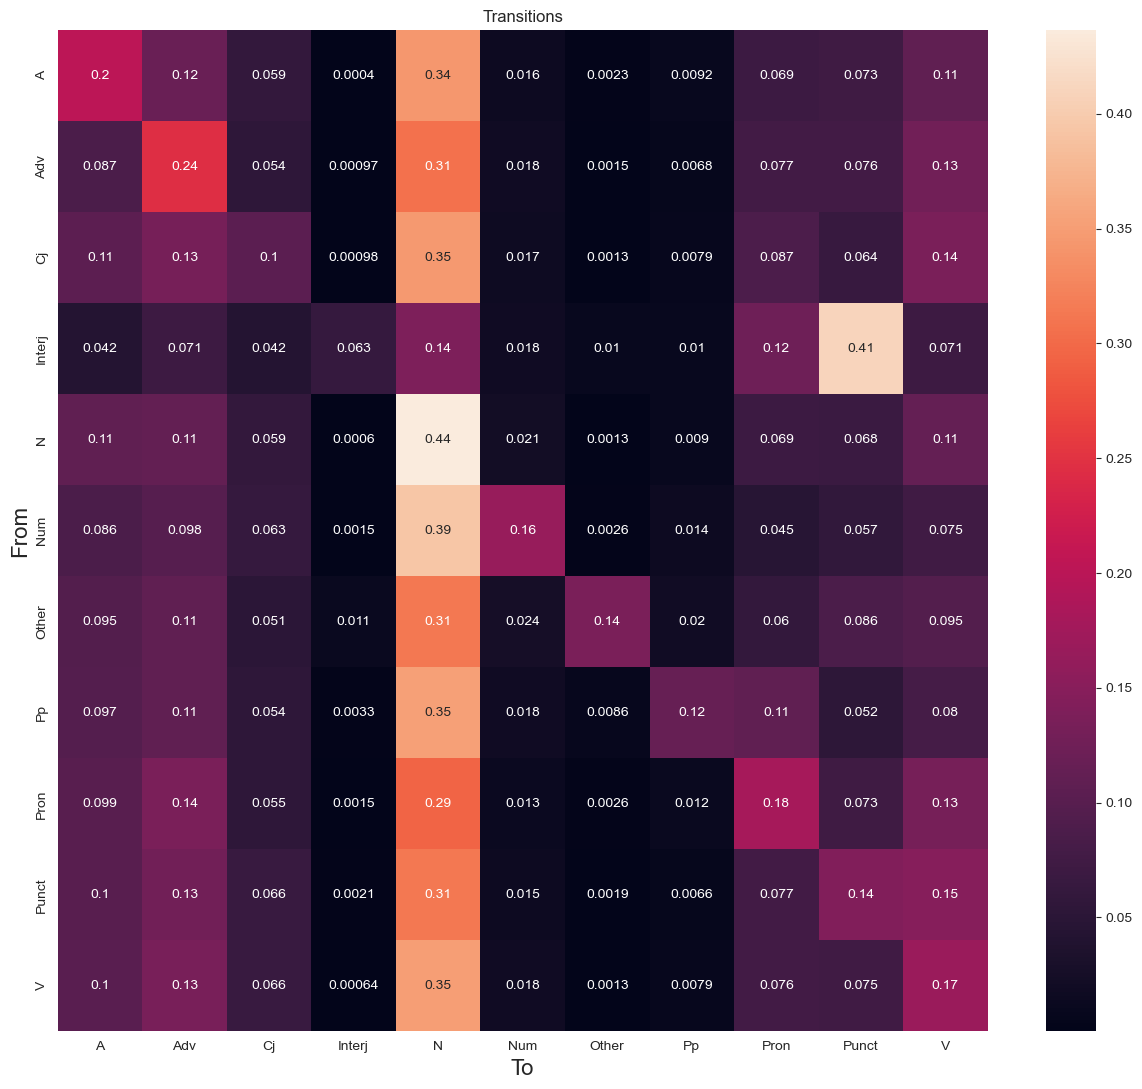

In [65]:
plt.figure(figsize=(15, 13))
transitions = pd.DataFrame.from_dict(get_transitions(df, 'pos_tags', laplace_smoothing=5))
sns.heatmap(transitions.T, annot=True)
plt.xlabel('To', fontsize=16)
plt.ylabel('From', fontsize=16)
plt.title('Transitions')
plt.show()

# Splitting data

In [14]:
def add_categories(df: pd.DataFrame) -> pd.DataFrame:
    df['sentence_length'] = pd.qcut(df.pos_tags.apply(lambda l : len(l)), 3, labels=['small', 'medium', 'long']).astype('string[pyarrow]')
    df['unique_pos'] = pd.qcut(df.pos_tags.apply(lambda l : len(set(l))), 3, labels=['low', 'medium', 'high']).astype('string[pyarrow]')
    df['starts_with'] = df.pos_tags.apply(lambda l : l[0]).astype('string[pyarrow]')
    return df

In [16]:
from sklearn.model_selection import train_test_split
TRAIN_PATH = os.path.join(DATA_FOLDER, 'train')
TEST_PATH = os.path.join(DATA_FOLDER, 'test')
RANDOM_STATE = 42
test_sets = []
for idx in range(1, NUM_PARTS + 1):
    df = get_dataset(idx)
    df = normalize_length(df)
    df = add_categories(df)
    train_df, test_df = train_test_split(df, test_size=0.3, random_state=RANDOM_STATE)
    # print(train_df)
    train_df.to_orc(os.path.join(TRAIN_PATH, f'train_{idx}.orc'))
    test_df.to_orc(os.path.join(TEST_PATH, f'test_{idx}.orc'))

